# Current Data Sources

1. Google Trends API
2. Twitter API

# Current Features
1. term	
2. current_popularity	
3. change_3mo	
4. change_6mo	
5. change_9mo	
6. change_12mo	
7. change_24mo	
8. popularity_2y	
9. sentiment
10. subjectivity

# Visulizations to make...
1. Sentiment PDF
2. popularity and predicted popularity

# Features to add...
1. sentiment standard deviation

In [1]:
#imports and instantiations
from pytrends.request import TrendReq
import tweepy
from statsmodels.tsa import ar_model, stattools, arima_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from textblob import TextBlob
import pandas as pd
from potosnail import Stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import numpy as np
import plotly.express as px

In [70]:
#helper functions
def GetReport(keywords, span='today 5-y', geo='', quiet=True):
    '''observe a search term's popularity in the past 5 years'''
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload(keywords, cat=0, timeframe=span, geo=geo, gprop='')
    ts = pytrends.interest_over_time().drop(['isPartial'], axis='columns')
    if quiet == False:
        print(ts.plot())
    return ts

def AnalyzeTwitter(keyword):
    '''find the average sentimental value and subjectivity of a given search term'''
    c1 = 'aHXduTrDkva3ItY52tUtYVPvA'
    c2 = 'Qs6d4oNT3zXxDqOhita7IG07CfAJGceoqIs1sGuA4OURlbLP6d'
    a1 = '1181578611171762177-sGQaj7E9fpWi2aEB3MfWL4nTRovXYk'
    a2 = 'wa77yBJZJSOKOAzdaJYDruc9U1HrGhzyDhWgKvSQpm2hv'
    auth = tweepy.OAuthHandler(c1, c2)
    auth.set_access_token(a1, a2)
    api = tweepy.API(auth)
    topic = api.search(keyword)
    sent = 0
    sub = 0
    sents = []
    for i in range(len(topic)):
        tweet = topic[i]._json['text'].replace('@', '')
        blob = TextBlob(tweet)
        sents.append(blob.sentiment[0])
        sent += blob.sentiment[0]/len(topic)
        sub += blob.sentiment[1]/len(topic)
    return sent, sub, sents

def Collect(keyword, quiet=True):
    '''tells us how popularity for a given search term is expected to change'''
    row = {}
    ts = GetReport([keyword])
    row['term'] = keyword
    model = ar_model.AutoReg(ts, lags=4).fit()
    pred = model.predict(start=260, end=356)
    current_popularity = np.array(ts)[-1][0]
    row['current_popularity'] =  current_popularity
    row['change_3mo'] = '{}%'.format(round(((pred[11] - current_popularity) / current_popularity) * 100, 1))
    row['change_6mo'] = '{}%'.format(round(((pred[23] - current_popularity) / current_popularity) * 100, 1))
    row['change_9mo'] = '{}%'.format(round(((pred[35] - current_popularity) / current_popularity) * 100, 1))
    row['change_12mo'] = '{}%'.format(round(((pred[47] - current_popularity) / current_popularity) * 100, 1))
    row['change_24mo'] = '{}%'.format(round(((pred[95] - current_popularity) / current_popularity) * 100, 1))
    row['popularity_2y'] = round((((pred[95] - current_popularity) / current_popularity) + 1) * current_popularity)
    estimated_reach = None
    estimated_clicks = None
    sentiment, subjectivity, sentiments = AnalyzeTwitter(keyword)
    row['sentiment'] = round(sentiment, 2)
    row['subjectivity'] = round(subjectivity, 2)
    row['sentiments_std'] = round(np.std(sentiments), 2)
    if quiet == True:
        return row
    else:
        ts['date'] = ts.index 
        pred2 = pd.DataFrame(pred)
        pred2.columns = [keyword]
        pred2['date'] = pred.index
        total = pd.concat([ts, pred2])
        return total, row

def CollectLoop(terms_list):
    '''tells us how popularity for a given list of search terms are expected to change'''
    df = pd.DataFrame(Collect(terms_list[0]), index=[0])
    for term in terms_list[1:]:
        temp = pd.DataFrame(Collect(term), index=[0])
        df = pd.concat([df, temp])
    return df.reset_index().drop(['index'], axis='columns')

def PlotOne(keyword):
    '''the output a user gets when looking at one term'''
    ts, results = Collect(keyword, quiet=False)
    subj = results['subjectivity']
    obj = 1 - subj
    X = ['%subjective', '%objective']
    y = [subj, obj]
    X2 = ['sentiment']
    y2 = results['sentiment']
    if results['popularity_2y'] > results['current_popularity']:
        future = 'increase'
    else:
        future = 'decrease'
    fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = results['sentiment'],
    mode = "gauge+number",
    title = {'text': "Sentiment of '{}' based on tweets".format(keyword)},
    gauge = {'axis': {'range': [-1, 1]},
             'steps' : [
                 {'range': [-1, 0], 'color': "red"},
                 {'range': [0, 1], 'color': "lightgreen"}]}))
    fig.show()
    fig = go.Figure(go.Indicator(
    domain = {'x': [0, 1], 'y': [0, 1]},
    value = results['subjectivity'],
    mode = "gauge+number",
    title = {'text': "Subjectivity of '{}' based on tweets".format(keyword)},
    gauge = {'axis': {'range': [0, 1]},
             'steps' : [
                 {'range': [0, 0.5], 'color': "yellow"},
                 {'range': [0.5, 1], 'color': "blue"}]}))
    fig.show()
    fig = px.line(ts, x='date', y=keyword, range_y=[0, 100])
    fig.show()
    
def PlotMany(keywords):
    for i in range(len(keywords)):
        ser = Collect(keywords[i], quiet=False)[0]
        fig = px.line(ser, x='date', y=keywords[i], range_y=[0, 100])
        fig.show()
        
def CheckSeasonality(ser):
    varience = 0
    for i in range(len(ser)):
        varience += abs(np.mean(ser)[0] - ser.iloc[i][0])
    delta = abs(np.mean(ser.iloc[235:])[0] - np.mean(ser.iloc[:27])[0])
    si = varience/delta
    if si <= 250:
        return True
    else:
        return False
    
def BuildTS(keyword):
    ser = GetReport([keyword])
    s = CheckSeasonality(ser)
    if s == True:
        my_order = (2,1,2) #probably wrong, also needs to be programatic
        my_seasonal_order = (2, 1, 2, 52) #probably wrong, also needs to be programatic
        model = SARIMAX(ser, order=my_order, seasonal_order=my_seasonal_order).fit()
        pred = model.predict(start=len(ser), end=356)
        ser_ = pd.DataFrame(ser)
        pred_ = pd.DataFrame(pred)
        pred_.columns = [keyword]
        ser_.columns = [keyword]
        return pd.concat([ser_, pred_]).reset_index()
    if s == False:
        model = ar_model.AutoReg(ser, lags=4).fit()
        pred = model.predict(start=ix, end=len(ser))
        ser_ = pd.DataFrame(ser)
        pred_ = pd.DataFrame(pred)
        pred_.columns = [keyword]
        ser_.columns = [keyword]
        return pd.concat([ser_, pred_]).reset_index()

In [71]:
hobbies = ['biking', 'gardening', 'surfing', 'home design', 'workouts']
products = ['face mask', 'bike helmet', 'board shorts', 'back brace', 'puzzles']

## How can this output be improved?
* improve the model and take seasonality into account
* make column names more user friendly

# Modeling
* Step 1: select 4 search term examples; an upward trend, a seasonal, a '2020' spike or dip, and a no trend
* Step 2: inspect acf and pacf for each
* Step 3: check for seasonality and stationarity
* Step 4: select the best model for each
* Step 5: Automate this process with OOP

## selecting search term examples

In [4]:
upward = GetReport(['mom jeans'])
seasonal = GetReport(['sleeping bags'])
spike_2020 = GetReport(['face mask'])
little_trend = GetReport(['ashtray'])

# Checking acf and pacf

In [5]:
upward_acf = stattools.acf(upward)
seasonal_acf = stattools.acf(seasonal)
spike_2020_acf = stattools.acf(spike_2020)
little_trend_acf = stattools.acf(little_trend)

upward_pacf = stattools.pacf(upward)
seasonal_pacf = stattools.pacf(seasonal)
spike_2020_pacf = stattools.pacf(spike_2020)
little_trend_pacf = stattools.pacf(little_trend)

# Modeling process
## for a given search term

1. check for seasonality
2. use ARIMA if there is no seasonality, otherwise use SARIMA
3. optimize lags programatically, use acf and pacf if nessecary
4. evaluate with AIC and BIC

helpful reference: https://towardsdatascience.com/time-series-essentials-fe6727ab6a94

## Next Steps
* wrap it all up in a master function
* wrap code into a Flask or Dash Framework
* deploy to heroku

don't get cocky, the seasonality function is still trash :)

In [62]:
test = GetReport(['graphic hoodie'])

In [63]:
#test['bugatti'] = test.index
test.reset_index()

,date,graphic hoodie
0,2016-04-03,14
1,2016-04-10,17
2,2016-04-17,6
3,2016-04-24,6
4,2016-05-01,3
...,...,...
255,2021-02-21,57
256,2021-02-28,57
257,2021-03-07,51
258,2021-03-14,52


70.97786647314967

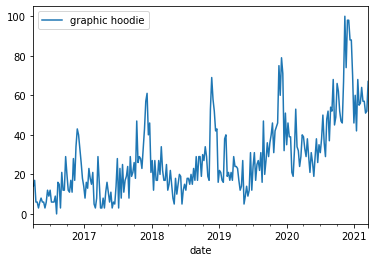

In [38]:
ser = test #GetReport(['socks'])
ser.plot()
CheckSeasonality(ser)

In [84]:
def _(keyword):
    row = {}
    tsdf = BuildTS(keyword)
    row['term'] = keyword
    current_popularity = list(tsdf[keyword][:260])[-1]
    row['current_popularity'] =  current_popularity
    try:
        row['change_3mo'] = '{}%'.format(round(((tsdf.iloc[271] - current_popularity) / current_popularity) * 100, 1))
    except:
        return tsdf[keyword][271]
    row['change_6mo'] = '{}%'.format(round(((tsdf.iloc[283] - current_popularity) / current_popularity) * 100, 1))
    row['change_9mo'] = '{}%'.format(round(((tsdf.iloc[295] - current_popularity) / current_popularity) * 100, 1))
    row['change_12mo'] = '{}%'.format(round(((tsdf.iloc[307] - current_popularity) / current_popularity) * 100, 1))
    row['change_24mo'] = '{}%'.format(round(((tsdf.iloc[355] - current_popularity) / current_popularity) * 100, 1))
    row['popularity_2y'] = round((((tsdf.iloc[355] - current_popularity) / current_popularity) + 1) * current_popularity)
    sentiment, subjectivity, sentiments = AnalyzeTwitter(keyword)
    row['sentiment'] = round(sentiment, 2)
    row['subjectivity'] = round(subjectivity, 2)
    row['sentiments_std'] = round(np.std(sentiments), 2)
    if quiet == True:
        return row
    else:
        ts['date'] = ts.index 
        pred2 = pd.DataFrame(pred)
        pred2.columns = [keyword]
        pred2['date'] = pred.index
        total = pd.concat([ts, pred2])
        return total, row
    
_('leggings')

67.57207417360198

In [ ]:
def Collect(keyword, quiet=True):
    '''tells us how popularity for a given search term is expected to change'''
    row = {}
    ts = GetReport([keyword])
    row['term'] = keyword
    model = ar_model.AutoReg(ts, lags=4).fit()
    pred = model.predict(start=260, end=356)
    current_popularity = np.array(ts)[-1][0]
    row['current_popularity'] =  current_popularity
    row['change_3mo'] = '{}%'.format(round(((pred[11] - current_popularity) / current_popularity) * 100, 1))
    row['change_6mo'] = '{}%'.format(round(((pred[23] - current_popularity) / current_popularity) * 100, 1))
    row['change_9mo'] = '{}%'.format(round(((pred[35] - current_popularity) / current_popularity) * 100, 1))
    row['change_12mo'] = '{}%'.format(round(((pred[47] - current_popularity) / current_popularity) * 100, 1))
    row['change_24mo'] = '{}%'.format(round(((pred[95] - current_popularity) / current_popularity) * 100, 1))
    row['popularity_2y'] = round((((pred[95] - current_popularity) / current_popularity) + 1) * current_popularity)
    estimated_reach = None
    estimated_clicks = None
    sentiment, subjectivity, sentiments = AnalyzeTwitter(keyword)
    row['sentiment'] = round(sentiment, 2)
    row['subjectivity'] = round(subjectivity, 2)
    row['sentiments_std'] = round(np.std(sentiments), 2)
    if quiet == True:
        return row
    else:
        ts['date'] = ts.index 
        pred2 = pd.DataFrame(pred)
        pred2.columns = [keyword]
        pred2['date'] = pred.index
        total = pd.concat([ts, pred2])
        return total, row